# Auto ML Hyperparameter Tuning

Here we will use PyCaret to determine what the  best machine learning models are for our application and what the best hyperparemeters for these models are.

This is a clustering problem, so most of the insights are already in the Clustering_Analysis notebook. Here we demonstrate how to use PyCaret to do similar things.

In [36]:
import rioxarray as rxr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from pycaret.clustering import *

# Path to your working directory to store the images
data_path = "/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data/ai_ready/" # This is an example, change it to your own path

In [37]:
blendDEM = rxr.open_rasterio(data_path + "blendDEM_aiready.tif", cache=False)
blendSLOPE = rxr.open_rasterio(data_path + "blendSLOPE_aiready.tif", cache=False)

ctxDEM = rxr.open_rasterio(data_path + "ctxDEM_aiready.tif", cache=False)
ctxIMG = rxr.open_rasterio(data_path + "ctxIMG_aiready.tif", cache=False)
ctxSLOPE = rxr.open_rasterio(data_path + "ctxSLOPE_aiready.tif", cache=False)

dayIR = rxr.open_rasterio(data_path + "dayIR_aiready.tif", cache=False)
nightIR = rxr.open_rasterio(data_path + "nightIR_aiready.tif", cache=False)

hrscND = rxr.open_rasterio(data_path + "hrscND_aiready.tif", cache=False)
hrscP1 = rxr.open_rasterio(data_path + "hrscP1_aiready.tif", cache=False)
hrscP2 = rxr.open_rasterio(data_path + "hrscP2_aiready.tif", cache=False)
hrscS1 = rxr.open_rasterio(data_path + "hrscS1_aiready.tif", cache=False)
hrscS2 = rxr.open_rasterio(data_path + "hrscS2_aiready.tif", cache=False)

training_imgs = [blendDEM, blendSLOPE, ctxDEM, ctxIMG, ctxSLOPE, dayIR, nightIR, hrscND, hrscP1, hrscP2, hrscS1, hrscS2]
training_names = ['blendDEM', 'blendSLOPE', 'ctxDEM', 'ctxIMG', 'ctxSLOPE', 'dayIR', 'nightIR', 'hrscND', 'hrscP1', 'hrscP2', 'hrscS1', 'hrscS2']

label_map = rxr.open_rasterio("/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data/label/validation_map.tif", cache=False)

Combine a subset of training images into one multi-band image for ML analysis.

In [38]:
# Combine the images into a multi-band image
subset_imgs = [blendDEM, blendSLOPE, ctxDEM, ctxIMG, ctxSLOPE, hrscND, hrscP1, hrscP2, hrscS1, hrscS2]
multi_band_image = np.stack([img.values[0] for img in subset_imgs], axis=-1)

# Flatten the multi-band image into a 2D array where each row represents a pixel and each column represents a band
pixels = multi_band_image.reshape(-1, multi_band_image.shape[-1])

# Convert to a DataFrame
df = pd.DataFrame(pixels, columns=[f'band_{i+1}' for i in range(multi_band_image.shape[-1])])
subset_size = 10000  # Adjust this size based on the desired subset size
df_subset = df.sample(n=subset_size, random_state=0)

## PyCaret - Clustering

Since the main technique we'd like to use is clustering (because we don't have a lot of label data), we will use PyCaret to optimize clustering methods. 

### K Means

In [39]:
clustering_setup = setup(data=df_subset)
kmeans_model = create_model('kmeans')  # Adjust the number of clusters as needed
evaluate_model(kmeans_model)

,Description,Value
0,Session id,914
1,Original data shape,"(10000, 10)"
2,Transformed data shape,"(10000, 10)"
3,Numeric features,10
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2762,3783.9395,1.2456,0,0,0


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Affinity Propogation

In [40]:
aff_model = create_model('ap')  # Adjust the number of clusters as needed
evaluate_model(aff_model)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1176,461.7107,1.4864,0,0,0


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Spectral Clustering

In [41]:
spectral_model = create_model('sc')  # Adjust the number of clusters as needed
evaluate_model(spectral_model)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2663,3500.3522,1.3251,0,0,0


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Agglomerative Clustering

In [42]:
agglom_model = create_model('hclust')  # Adjust the number of clusters as needed
evaluate_model(agglom_model)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1925,2848.1035,1.5126,0,0,0


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

It looks like Spectral and K Means clustering perform the best based on silhouette score. Let's see some diagnostics with Kmeans, since its easy to use and flexible with number of clusters.

## Diagnostics for K means clustering

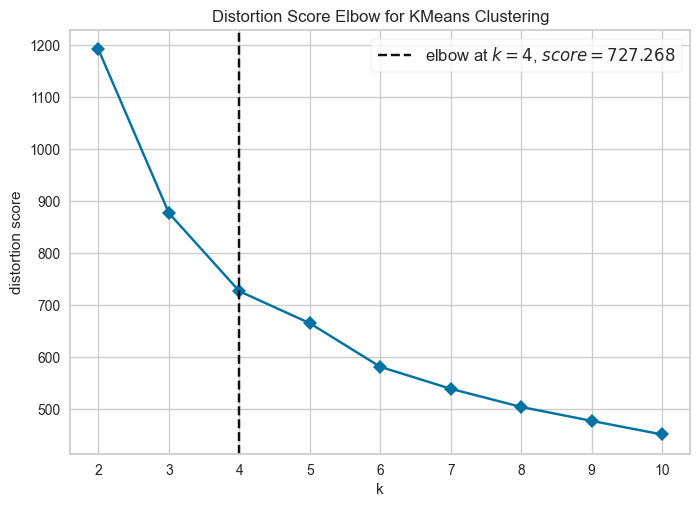

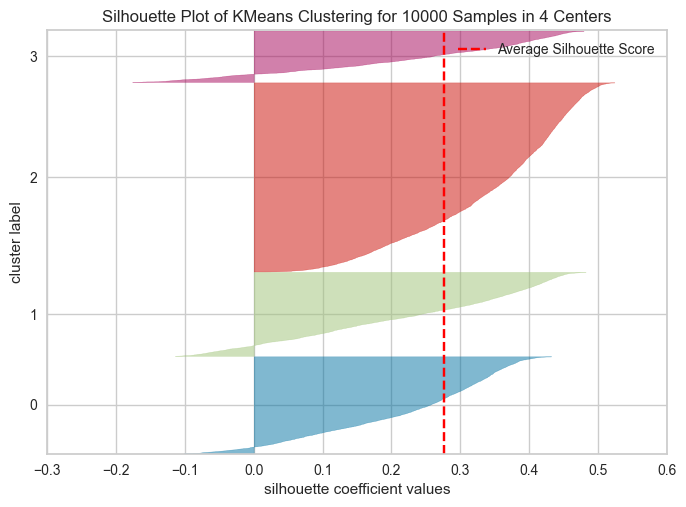

In [44]:
# Plot the cluster centers
plot_model(kmeans_model, plot='cluster')

# Plot the elbow method to find the optimal number of clusters
plot_model(kmeans_model, plot='elbow')

# Plot the silhouette plot
plot_model(kmeans_model, plot='silhouette')

# Plot the distribution of clusters
plot_model(kmeans_model, plot='distribution')

# Show all plots
plt.show()

PyCaret says the elbow in number of clusters is at 4, but it doesn't look much like an elbow - it looks more exponential. From this, I think 8 clusters is the number that maximizes performance.

Even though K means achieves the best silhoutte score, its still not very high. This indicates to me that this problem is difficult and image segmentation like this does not have clear, easily defined feature classes.